In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path

from PyLorentz.io import read_image


import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from PyLorentz.visualize import show_im, show_2D
from PyLorentz.phase.DIP_NN import DIP_NN
from PyLorentz.phase.AD_funcs import training_loop, sim_images_torch
from PyLorentz.phase.AD_utils import induction_from_phase, get_all_accs, get_TF  # put induction_from_phase in utils, is useful, can leave in base phase too
from PyLorentz.utils.microscopes import Microscope
from PyLorentz.utils.noise import ImageNoiser
from PyLorentz.sim import SimLTEM

import copy
from PyLorentz.phase import SITIE

print(f"There are {torch.cuda.device_count()} GPU(s) available")
device_ind = 0
print(f"Proceeding with GPU {device_ind}: {torch.cuda.get_device_name(device_ind)}")
device = torch.device(f'cuda:{device_ind}')

There are 1 GPU(s) available
Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


TODO 
1. update the image simulation part to be using SIMLTEM instead 
2. classes for SIPRAD recon 
3. demo of SIPRAD with amplitude
4. demo of SIPRAD with experimental data 

Text file found: d:\code\PyLorentz\Examples\data\CGT_sim_B0G.ovf
Simulation size (z, y, x) : (10, 512, 512)
Image (x-y) scale : 4 nm/pixel.
Out-of-plane (z) scale : 10 nm/pixel.


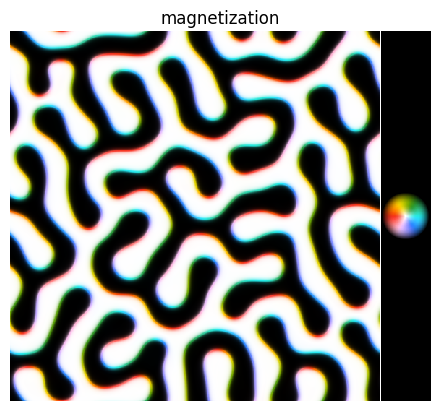

In [3]:
mag_f = Path("./data/CGT_sim_B0G.ovf")
simulator = SimLTEM.load_ovf(mag_f)
simulator.show_mags()

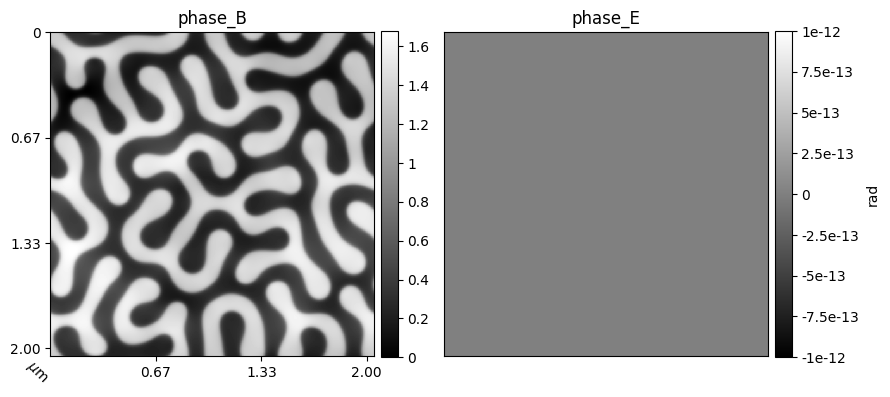

Simulating images for defocus values: -1 mm


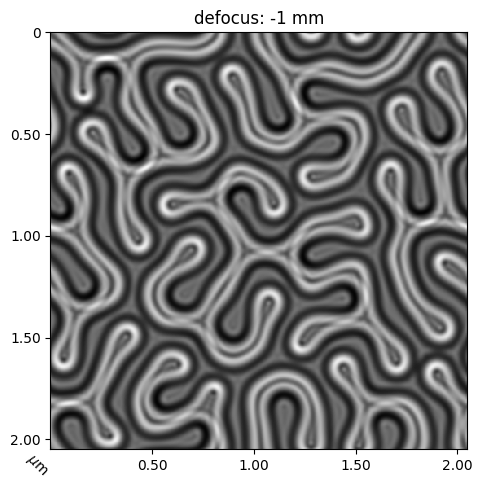

In [4]:
scope = Microscope(
    E=200e3,
    Cs=200e3,
    theta_c=0.01e-3,
    def_spr=80,
)

sample_params = {"B0" : 2.5e3}
simulator.set_sample_params(sample_params)
simulator.compute_phase(method="mans", beam_energy=scope.E)
simulator.show_phase()

defvals = [-1_000_000] # -1mm
dd = simulator.sim_images(defocus_values=defvals, scope=scope)

dd.show_im()

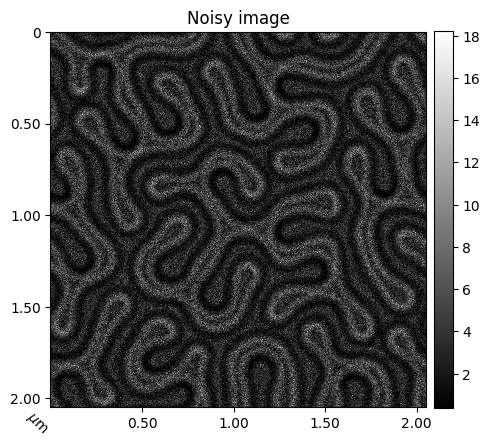

In [7]:
GNoise = 0

noiser = ImageNoiser(
    gauss = GNoise, # percent noise, 0+
    poisson = 1e6, # 1e7, total counts/intensity
    salt_and_pepper = 0, # 0+, ~10
    blur = 0, # sigma, 0+, ~0.5
    contrast = None, # 1-, 1+
    bkg = 0, # 0+, ~1
    seed = 42,
)

inp_ims = noiser.run(dd.images)

noisy_dd = copy.deepcopy(dd)
noisy_dd.images = inp_ims
noisy_dd.show_im(title="Noisy image", cbar=True)


In [28]:
from PyLorentz.phase.AD_phase import ADPhase


LRs = {
    "phase": 2e-4, # 2e-4 for DIP, 0.2 otherwise
    "amp": 2e-4, # 2e-4 for DIP, 0.02 otherwise
    "amp_scale": 0.1, # used when not solve_amp, 0.1 best
    "TV_phase_weight": 5e-3, # only used if reconstructing without DIPs
    "TV_amp_weight": 5e-3, # only used if reconstructing without DIPs
}

sample_params = {
    "dirt_V0" : 20,
    "dirt_xip0" : 10,
}


siprad = ADPhase(
    dd=noisy_dd,
    device=device,
    scope=scope,
    sample_params=sample_params,
    LRs=LRs,
    scheduler_type=None,
    noise_frac=1/30,
    guess_phase="SITIE",
    gaussian_sigma=2,
)

DIP_phase = DIP_NN()


Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


Beginning pretraining


100%|██████████| 200/200 [00:02<00:00, 69.33it/s]


Reconstructing


100%|██████████| 1000/1000 [00:14<00:00, 69.90it/s]


total time (h:m:s) = 0:00:17


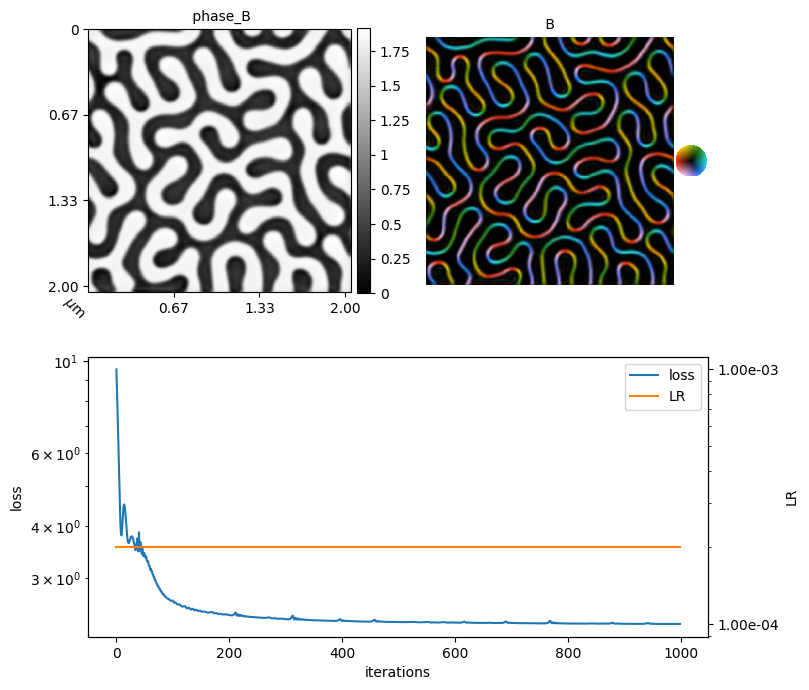

SIPRAD  phase: acc 97.6% SSIM 0.858  |  Bave: acc 96.8% SSIM 0.886
SITIE   phase: acc 89.6% SSIM 0.475  |  Bave: acc 87.5% SSIM 0.680


In [29]:
siprad.reconstruct(
    num_iter=1000,
    model = DIP_phase,
    num_pretrain_iter=200,
    solve_amp=False,
    solve_amp_scale = True,
    guess_amp=np.ones_like(inp_ims)[0],
    reset=True, # will reset model weights
    print_every = -1,
    save_iters_every=100,
    verbose = 1, # verbose = 2 to show plots
)

siprad.visualize()

siprad_metrics = siprad.calc_phase_metrics(simulator.phase_B, siprad.best_phase)
sitie_metrics = siprad.calc_phase_metrics(simulator.phase_B, siprad.guess_phase)
print(f"{'SIPRAD':8} phase: acc {siprad_metrics['acc_phase']*100:.1f}% SSIM {siprad_metrics['SSIM_phase']:.3f} | Bave: acc {siprad_metrics['acc_Bave']*100:.1f}% SSIM {siprad_metrics['SSIM_Bave']:.3f}")
print(f"{'SITIE':8} phase: acc {sitie_metrics['acc_phase']*100:.1f}% SSIM {sitie_metrics['SSIM_phase']:.3f} | Bave: acc {sitie_metrics['acc_Bave']*100:.1f}% SSIM {sitie_metrics['SSIM_Bave']:.3f}")

TODO 
1. figure out way to add more params to optimizer, rewrite the optimizer setup 
1. add amp_scale to params, and argument for reconstructing when just doing no amp reconstruction 
2. add accuracy func to base class
2. test simulated with amp variation, double DIP but more importantly a fixed guess_amp
3. test with experimental CGT data


In [ ]:
pred_phase = DIP_phase.forward(adp._input_DIP).squeeze()
loss = torch.mean((pred_phase - adp.guess_phase)**2)
print('loss: ', loss)
show_im(pred_phase.cpu().detach().numpy())

In [ ]:
show_im(adp.guess_phase.cpu().detach().numpy())

In [ ]:
show_im(adp.guess_phase.cpu().detach().numpy())
show_im(input_noise.cpu().detach().numpy())

In [ ]:
from tqdm import tqdm
DIP_phase = DIP_NN().to(device)
opt = torch.optim.Adam([{"params": DIP_phase.parameters(), "lr": 2e-4}])

input_noise = adp._rng.random((1, *adp.shape))*3
input_noise = torch.tensor(input_noise, device=adp.device, dtype=torch.float32)
losses = []
for i in tqdm(range(500)):
    # pred_phase = DIP_phase.forward(input_noise).squeeze()
    pred_phase = DIP_phase.forward(adp.guess_phase[None]).squeeze()
    loss = torch.mean((pred_phase - adp.guess_phase)**2)
    # print(f"loss: {loss:.2e}")
    loss.backward()
    opt.step()
    opt.zero_grad()
    losses.append(loss.item())

show_im(pred_phase.cpu().detach().numpy())
fig, ax = plt.subplots()
ax.plot(losses)
plt.show()

In [ ]:

pdict = {}
pdict['scale'] = dd.scale
pdict['save_home'] = "./"
pdict['dataname'] = "SIPRAD_demo_CGT"
pdict['device'] = device
pdict['mode'] = "sim"

pdict["defvals"] = np.array(defvals)
pdict['noise_vals'] = noiser.__dict__

pdict['DIP'] = True # Whether or not to use a DIP
pdict['solve_amp'] = False
pdict['notes'] = ""

pdict['show'] = True

pdict['maxiter'] = 1000 # convergence speed varies, but 1000 iters should be plenty
pdict['pre-train_dip'] = 500
pdict['scheduler'] = "plateau" # none, cyclic, plateau, exp
pdict['plateau_patience'] = 50

optLR = [0.2, 0.02] # (phase LR, amp LR) if not using DIP
dipLR = [2e-4, 2e-4] # LR for DIP, (phase, amp)
tvLR = [0.005, 0] # (phase TV weight, amp TV weight) (1,0) for small, only if not using DIP
sigma = 2 # gaussian smoothing output phase
pdict['DIP_noise_frac'] = 0 if pdict['solve_amp'] else 1/30
pdict["start_mode"] = "random" if pdict['solve_amp'] else "SITIE" # random, uniform, true_phase, SITIE


plt.close('all')

### define the guess or input phase/amps
if pdict["start_mode"] == "random":
    inp_phase = np.random.rand(*inp_ims[0].shape)*2-1
elif pdict["start_mode"] == "uniform":
    inp_phase = np.zeros(inp_ims[0].shape)
elif pdict["start_mode"] == "true_phase":
    inp_phase = np.copy(true_phase)
elif pdict["start_mode"] == "SITIE":
    if pdict['solve_amp']:
        print("\n============\nStarting with SITIE for solve amp, not recommended\n===========\n")
    # inp_phase = SITIE(inp_ims[0].cpu().detach().numpy(),
    #                     dfs[0], pdict['scale'], v=0)['phase_b']
    # sitie = SITIE.from_array(
    #     image = inp_ims[0].cpu().detach().numpy(),
    #     scale = scale,
    #     defval = dfs[0],
    #     beam_energy = scope.E,
    #     simulated = True,
    # )
    sitie = SITIE(noisy_dd)
    sitie.reconstruct().visualize()
    inp_phase = sitie.phase_B.copy()
    show_im(inp_phase-inp_phase.min(), "input phase from SITIE")

guess_phase = torch.tensor(inp_phase, dtype=torch.float32, device=device,
                           requires_grad=True)
guess_amp = torch.tensor(np.ones_like(noisy_dd.images)*np.sqrt(noisy_dd.images.mean()), device=device, dtype=torch.float32, requires_grad=False)

if pdict['DIP']:
    dipP = DIP_NN().to(device)

    dipA = None
    optimizer = torch.optim.Adam([
        {'params': dipP.parameters(), 'lr':dipLR[0]},
        ])
    tvLR = [0, 0] # not strictly necessary as if pdict['DIP'] then TV loss won't be calc
    LRs = dipLR # for scheduler

else:
    dipP = None
    dipA = None
    optimizer = torch.optim.Adam([
        {'params': guess_phase, 'lr':optLR[0]}
        ])
    LRs = optLR

pdict["LRs"] = [optLR, tvLR, dipLR]
inp_ims = torch.tensor(inp_ims, device=pdict['device'])
guess_amp, guess_phase, best_amp, best_phase, losses = training_loop(inp_ims,
                                                                     guess_amp,
                                                                     guess_phase,
                                                                     TFs,
                                                                     pdict,
                                                                     dipA,
                                                                     dipP,
                                                                     print_every = 200)
losses=np.array(losses)
fig, ax = plt.subplots(ncols=2, figsize = (8,3))
ax[0].plot(losses[:,0])
ax[0].set_xlabel("iterations")
ax[0].set_ylabel("loss")
ax[1].semilogy(losses[:,0], label='losses')
ax[1].set_xlabel("iterations")
ax2 = ax[1].twinx()
ax2.plot(losses[:,1],color='orange', label='LR')
plt.legend()
minloss_iter = np.argmin(losses[:,0])
fphase = guess_phase.cpu().detach().numpy()
bphase = best_phase.cpu().detach().numpy()
fphase = ndi.gaussian_filter(fphase, sigma, mode='wrap')
bphase = ndi.gaussian_filter(bphase, sigma, mode='wrap')
gamp = guess_amp.cpu().detach().numpy()
bamp = best_amp.cpu().detach().numpy()
gamp = ndi.gaussian_filter(gamp, sigma, mode='wrap')
bamp = ndi.gaussian_filter(bamp, sigma, mode='wrap')
final_By, final_Bx = induction_from_phase(fphase, pdict['scale'])
best_By, best_Bx = induction_from_phase(bphase, pdict['scale'])

show_im(fphase, "final phase", cbar_title="rad")
true_phase = simulator.phase_B
a = true_phase.shape[0]//16
pdict['acc_crop'] = a
get_all_accs(fphase[a:-a,a:-a], bphase[a:-a,a:-a], true_phase[a:-a,a:-a], pdict)

print(f"\nGuess phi accuracy {pdict['guess_phi_acc']*100:.3f}% best accuracy: {pdict['best_phi_acc']*100:.3f}%")
print(f"Guess phi SS {pdict['guess_phi_SS']*100:.3f} best phi SS: {pdict['best_phi_SS']*100:.3f}")

print(f"Guess B accuracy (Bx, By, Bmag) ({pdict['guess_Bx_acc']*100:.3f}, {pdict['guess_By_acc']*100:.3f}, {pdict['guess_Bmag_acc']*100:.3f})%  best accuracy: ({pdict['best_Bx_acc']*100:.3f}, {pdict['best_By_acc']*100:.3f}, {pdict['best_Bmag_acc']*100:.3f})%")
print(f"Guess B SS (Bx, By, Bmag) ({pdict['guess_Bx_SS']*100:.3f}, {pdict['guess_By_SS']*100:.3f}, {pdict['guess_Bmag_SS']*100:.3f})  best B SS: ({pdict['best_Bx_SS']*100:.3f}, {pdict['best_By_SS']*100:.3f}, {pdict['best_Bmag_SS']*100:.3f})\n")

show_im(fphase, title="Reconstructed phase", cbar_title="rad")
show_2D(final_Bx, final_By, a=0, cmap='hsv', title="Reconstructed integrated induction")

In [ ]:
show_im(simulator.phase_B)
show_im(fphase)
show_im(sitie.phase_B)

# Old

In [ ]:
phase_f = Path("./data/CGT_phaseshift.tif")
true_phase, mdata = read_image(phase_f)
scale = mdata["scale"]
show_im(true_phase, title="True phase", scale=scale, cmap="viridis", cbar_title="rad")


pdict = {}
pdict['scale'] = scale
pdict['save_home'] = "./"
pdict['dataname'] = "SIPRAD_demo_CGT"
pdict['device'] = device
pdict['mode'] = "sim"

In [ ]:
true_By, true_Bx = induction_from_phase(true_phase, scale)
show_2D(true_Bx, true_By, a=0, cmap='hsv', title="True integrated induction")

In [ ]:
true_amp = np.ones_like(true_phase)

dfs = [-1_000_000] # -1mm
beam_energy = 200e3
scope = Microscope(E=beam_energy, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
GNoise = 0 # % Gaussian noise

noiser = image_noiser(
    gauss = GNoise, # percent noise, 0+
    poisson = 0.6, # 0+ , ~0.4
    salt_and_pepper = 0, # 0+, ~10
    blur = 0, # sigma, 0+, ~0.5
    contrast = None, # 1-, 1+
    bkg = 0, # 0+, ~1
    seed = 42,
)

pdict["defvals"] = np.array(dfs)
pdict['noise_vals'] = noiser.__dict__
print(f"defvals (mm): {pdict['defvals']/1e6}")

TFs = torch.tensor(np.array([get_TF(scope, true_phase.shape, defval, pdict["scale"]) for defval in pdict["defvals"]]),
                         device=device)

inp_ims_nonoise = sim_images_torch(torch.tensor(true_phase, device=device),
                     TFs,
                     torch.tensor(true_amp, device=device),
                     )

inp_ims = noiser.run(inp_ims_nonoise).float()
show_im(inp_ims[0].cpu().detach().numpy(), scale=pdict['scale'], title=f"defocus: {pdict['defvals'][0]/1e6} mm | G noise = {noiser.gauss}%")

In [ ]:
pdict['DIP'] = True # Whether or not to use a DIP
pdict['solve_amp'] = False
pdict['notes'] = ""

pdict['show'] = True

pdict['maxiter'] = 1000 # convergence speed varies, but 1000 iters should be plenty
pdict['pre-train_dip'] = 500
pdict['scheduler'] = "plateau" # none, cyclic, plateau, exp
pdict['plateau_patience'] = 50

optLR = [0.2, 0.02] # (phase LR, amp LR) if not using DIP
dipLR = [2e-4, 2e-4] # LR for DIP, (phase, amp)
tvLR = [0.005, 0] # (phase TV weight, amp TV weight) (1,0) for small, only if not using DIP
sigma = 2 # gaussian smoothing output phase
pdict['DIP_noise_frac'] = 0 if pdict['solve_amp'] else 1/30
pdict["start_mode"] = "random" if pdict['solve_amp'] else "SITIE" # random, uniform, true_phase, SITIE


plt.close('all')

### define the guess or input phase/amps
if pdict["start_mode"] == "random":
    inp_phase = np.random.rand(*inp_ims[0].shape)*2-1
elif pdict["start_mode"] == "uniform":
    inp_phase = np.zeros(inp_ims[0].shape)
elif pdict["start_mode"] == "true_phase":
    inp_phase = np.copy(true_phase)
elif pdict["start_mode"] == "SITIE":
    if pdict['solve_amp']:
        print("\n============\nStarting with SITIE for solve amp, not recommended\n===========\n")
    # inp_phase = SITIE(inp_ims[0].cpu().detach().numpy(),
    #                     dfs[0], pdict['scale'], v=0)['phase_b']
    sitie = SITIE.from_array(
        image = inp_ims[0].cpu().detach().numpy(),
        scale = scale,
        defval = dfs[0],
        beam_energy = scope.E,
        simulated = True,
    )
    sitie.reconstruct()
    inp_phase = sitie.phase_B.copy()
    show_im(inp_phase-inp_phase.min(), "input phase from SITIE")

guess_phase = torch.tensor(inp_phase, dtype=torch.float32, device=device,
                           requires_grad=True)
guess_amp = torch.tensor(torch.ones(inp_phase.shape, device=device)*torch.sqrt(inp_ims.mean()), device=device, dtype=torch.float32, requires_grad=False)

if pdict['DIP']:
    dipP = DIP_NN().to(device)

    dipA = None
    optimizer = torch.optim.Adam([
        {'params': dipP.parameters(), 'lr':dipLR[0]},
        ])
    tvLR = [0, 0] # not strictly necessary as if pdict['DIP'] then TV loss won't be calc
    LRs = dipLR # for scheduler

else:
    dipP = None
    dipA = None
    optimizer = torch.optim.Adam([
        {'params': guess_phase, 'lr':optLR[0]}
        ])
    LRs = optLR

pdict["LRs"] = [optLR, tvLR, dipLR]
guess_amp, guess_phase, best_amp, best_phase, losses = training_loop(inp_ims,
                                                                     guess_amp,
                                                                     guess_phase,
                                                                     TFs,
                                                                     pdict,
                                                                     dipA,
                                                                     dipP,
                                                                     print_every = 200)
losses=np.array(losses)
fig, ax = plt.subplots(ncols=2, figsize = (8,3))
ax[0].plot(losses[:,0])
ax[0].set_xlabel("iterations")
ax[0].set_ylabel("loss")
ax[1].semilogy(losses[:,0], label='losses')
ax[1].set_xlabel("iterations")
ax2 = ax[1].twinx()
ax2.plot(losses[:,1],color='orange', label='LR')
plt.legend()
minloss_iter = np.argmin(losses[:,0])
fphase = guess_phase.cpu().detach().numpy()
bphase = best_phase.cpu().detach().numpy()
fphase = ndi.gaussian_filter(fphase, sigma, mode='wrap')
bphase = ndi.gaussian_filter(bphase, sigma, mode='wrap')
gamp = guess_amp.cpu().detach().numpy()
bamp = best_amp.cpu().detach().numpy()
gamp = ndi.gaussian_filter(gamp, sigma, mode='wrap')
bamp = ndi.gaussian_filter(bamp, sigma, mode='wrap')
final_By, final_Bx = induction_from_phase(fphase, pdict['scale'])
best_By, best_Bx = induction_from_phase(bphase, pdict['scale'])

show_im(fphase, "final phase", cbar_title="rad")
a = true_phase.shape[0]//16
pdict['acc_crop'] = a
get_all_accs(fphase[a:-a,a:-a], bphase[a:-a,a:-a], true_phase[a:-a,a:-a], pdict)

print(f"\nGuess phi accuracy {pdict['guess_phi_acc']*100:.3f}% best accuracy: {pdict['best_phi_acc']*100:.3f}%")
print(f"Guess phi SS {pdict['guess_phi_SS']*100:.3f} best phi SS: {pdict['best_phi_SS']*100:.3f}")

print(f"Guess B accuracy (Bx, By, Bmag) ({pdict['guess_Bx_acc']*100:.3f}, {pdict['guess_By_acc']*100:.3f}, {pdict['guess_Bmag_acc']*100:.3f})%  best accuracy: ({pdict['best_Bx_acc']*100:.3f}, {pdict['best_By_acc']*100:.3f}, {pdict['best_Bmag_acc']*100:.3f})%")
print(f"Guess B SS (Bx, By, Bmag) ({pdict['guess_Bx_SS']*100:.3f}, {pdict['guess_By_SS']*100:.3f}, {pdict['guess_Bmag_SS']*100:.3f})  best B SS: ({pdict['best_Bx_SS']*100:.3f}, {pdict['best_By_SS']*100:.3f}, {pdict['best_Bmag_SS']*100:.3f})\n")

show_im(fphase, title="Reconstructed phase", cbar_title="rad")
show_2D(final_Bx, final_By, a=0, cmap='hsv', title="Reconstructed integrated induction")

In [ ]:
show_im(simulator.phase_B)

In [ ]:
show_im(fphase-fphase.min())

In [ ]:
show_im(sitie.phase_B)